### 1. Import libraries

In [30]:
from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

import matplotlib.pyplot as plt

from varname import nameof
import pyvista as pv

### 2. Read and preprocess of the data

In [31]:
# Assuming your data preparation steps are done here
num_simulations = 200
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data_concat.npy')
velocity_data = np.load('training_data/velocity_data_concat.npy')
points_data = np.load('training_data/points_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data_concat.npy')

In [32]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)
train_points, test_points = train_test_split(points_data, train_size=train_ratio, random_state=random_state)

In [33]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. POD and plot the truncated energy norm

In [46]:
def train_pod(train_data, plot_singular_values=False, epsilon=1e-8):
    # Perform POD on the training data
    modes, singular_values, coeffs = np.linalg.svd(train_data.T, full_matrices=False)
    mode_coeffs = np.matmul(np.diag(singular_values), coeffs).T

    # Truncate the modes based on the energy norm if the epsilon is provided
    if epsilon:
        truncated_energy = 1-np.cumsum(np.square(singular_values))/np.sum(np.square(singular_values))
        num_modes = np.argmax(truncated_energy < epsilon)
        modes = modes[:, :num_modes]
        mode_coeffs = mode_coeffs[:, :num_modes]
    
        if plot_singular_values:
            plt.plot(truncated_energy)
            # plt.title(f'Truncation energy of {nameof(train_data)}')
            plt.yscale('log')
            plt.xlabel('Mode number')
            plt.ylabel('Truncation energy norm')
            plt.show() 

    return modes, mode_coeffs

### 4. RBF to interpolate the parameters

In [35]:
# Define a funtion to write the data into a VTK file
def vtk_writer(field_data, field_name, data_type,
               refVTM, save_path_name, points_data = None):
    # Add velocity data to each block within the MultiBlock dataset
    
    for block_i in range(refVTM.n_blocks):
        block = refVTM[block_i]
        if block is not None:
            if data_type == 'scalar':
                for data_i in range(len(field_name)):
                    block.cell_data[field_name[data_i]] = field_data[data_i]
            elif data_type == 'vector':
                for data_i in range(len(field_name)):
                    field = field_data[data_i].reshape(3, -1).T
                    block.cell_data[field_name[data_i]] = field 
            if points_data is not None:
                points = points_data.reshape(3, -1).T
                block.points = points

    # Save the modified VTM file
    output_vtm_file_path = f'{save_path_name}.vtm'
    refVTM.save(output_vtm_file_path)

In [36]:
# Define a function to evaluate RBF with different parameters
def evaluate_rbf(x,y):
    # List of kernel functions to test
    kernels = ['linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 'inverse_multiquadric', 'gaussian']
    epsilons = np.logspace(-3, 3, 7)

    best_kernel = None
    best_epsilon = float('inf')
    best_score = float('inf')
    
    for kernel in kernels:
        for epsilon in epsilons:
            # print(f'Kernel: {kernel}, Epsilon: {epsilon}')

            # use try to avoid any errors
            try:
                rbf_model = RBFInterpolator(x, y, kernel=kernel, epsilon=epsilon)
                y_pred = rbf_model(x)

                # Evaluate performance
                score = mean_squared_error(y, y_pred)
                
                # Update the best kernel if current score is better
                if score < best_score:
                    best_epsilon = epsilon
                    best_kernel = kernel
                    best_score = score
            except:
                # print(f'Error occured with kernel: {kernel}, Epsilon: {epsilon}')   
                continue         
    
    print(f'Best kernel: {best_kernel}, Best epsilon: {best_epsilon}, Best MSE: {best_score}')
    
    return best_kernel, best_epsilon

In [43]:
def PODI(train_data, test_data, points_data, data_name,
         data_type, vis_save_folder, plot_singular_values=False, epsilon=1e-6):

    modes, mode_coeffs = train_pod(train_data, plot_singular_values, epsilon)

    print(f'Number of modes: {modes.shape[1]}')

    # evaluate the best RBF model
    # Scale the data
    scaler = StandardScaler()
    train_design_parameters_scaled = scaler.fit_transform(train_design_parameters)
    best_kernel, best_epsilon = evaluate_rbf(train_design_parameters_scaled, mode_coeffs)

    # Train the RBF model
    rbf_model = RBFInterpolator(train_design_parameters_scaled, mode_coeffs, kernel=best_kernel, epsilon=best_epsilon)

    # try to interpolate the modes_coeffs with the trained RBF model using test_design_parameters
    # loop all test data and calculate the error
    test_design_parameters_scaled = scaler.transform(test_design_parameters)
    test_modes_coeffs = rbf_model(test_design_parameters_scaled)
    reconstructed_field = np.dot(modes, test_modes_coeffs.T).T
    error_field = test_data - reconstructed_field

    # calculate the reconstrcuted error for each test data using mean squared error
    reconstructed_error = np.linalg.norm(test_data - reconstructed_field, axis=1) / np.linalg.norm(test_data, axis=1)

    # write the truth data, reconstructed data, and error into a VTK file
    # Load the reference VTM file
    refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
    field_name = ['truth', 'reconstructed', 'error']
    # loop all test data and write the data into VTK file
    for i in range(len(test_data)):
        vtk_writer([test_data[i], reconstructed_field[i], error_field[i]], 
                   field_name, data_type, refVTM, f'{vis_save_folder}/test_case_{i}_{data_name}', points_data[i])

    # plot the error
    plt.bar([i for i in range(len(test_data))], reconstructed_error)
    plt.title('Reconstructed error')
    plt.xlabel('Test data')
    plt.ylabel('Reconstructed error')
    plt.show()

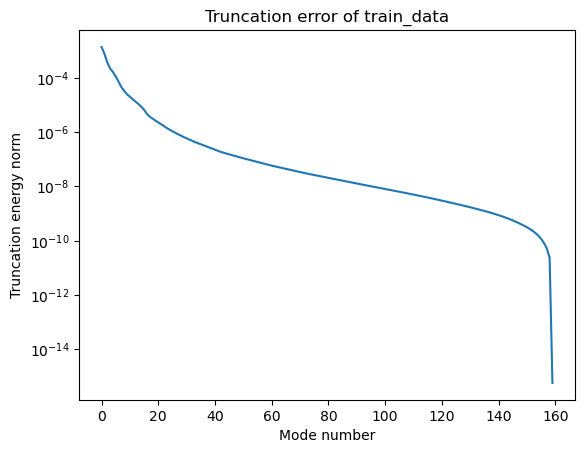

Number of modes: 6
Best kernel: gaussian, Best epsilon: 10.0, Best MSE: 9.88121240067436e-36


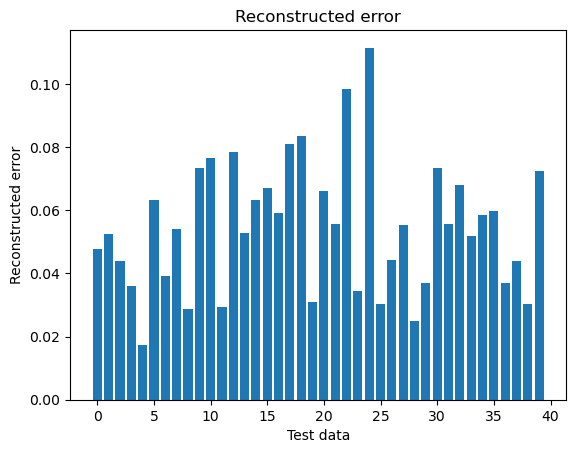

In [45]:
# Perform PODI on the pressure data
PODI(train_pressure, test_pressure, test_points, "pressure", "scalar", "visualization_data", 
     plot_singular_values=True, epsilon=1e-4)

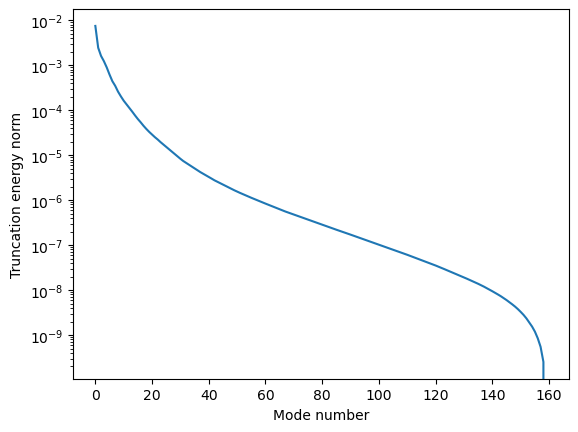

Number of modes: 57
Best kernel: gaussian, Best epsilon: 10.0, Best MSE: 1.4153590250668321e-36


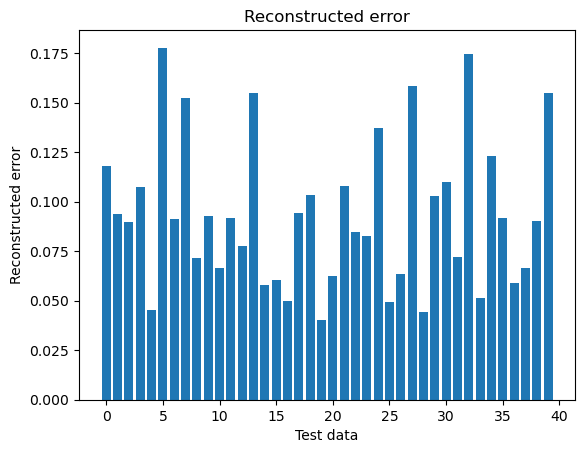

In [48]:
# Perform PODI on the velocity data
PODI(train_velocity, test_velocity, test_points, "velocity", "vector", "visualization_data",
     plot_singular_values=True, epsilon=1e-6)